In [135]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

In [143]:
tasks_fn = 'resources/house_target_tuple.json'
games_fn = '../tasks/dialog_navigation/all.json'
instruction_following_dir = '../tasks/instruction_following/'
folds = ["train", "val_seen", "val_unseen", "test"]

with open(tasks_fn, 'r') as f:
    house_target_tuple = json.load(f)

In [144]:
# Enumerate distances inside of task tuple data.
task_ds = []
for house in house_target_tuple:
    for _, _, _, _, end_pano_ds in house_target_tuple[house]:
        task_ds.append(min(end_pano_ds))

In [145]:
# Enumrate distances inside of matterport R2R data.
mp_ds = []
for fn in ['../../../tasks/R2R/data/R2R_train.json',
           '../../../tasks/R2R/data/R2R_val_seen.json',
           '../../../tasks/R2R/data/R2R_val_unseen.json']:
    with open(fn, 'r') as f:
        mp_data = json.load(f)
    for trajectory in mp_data:
        mp_ds.append(len(trajectory['path']))

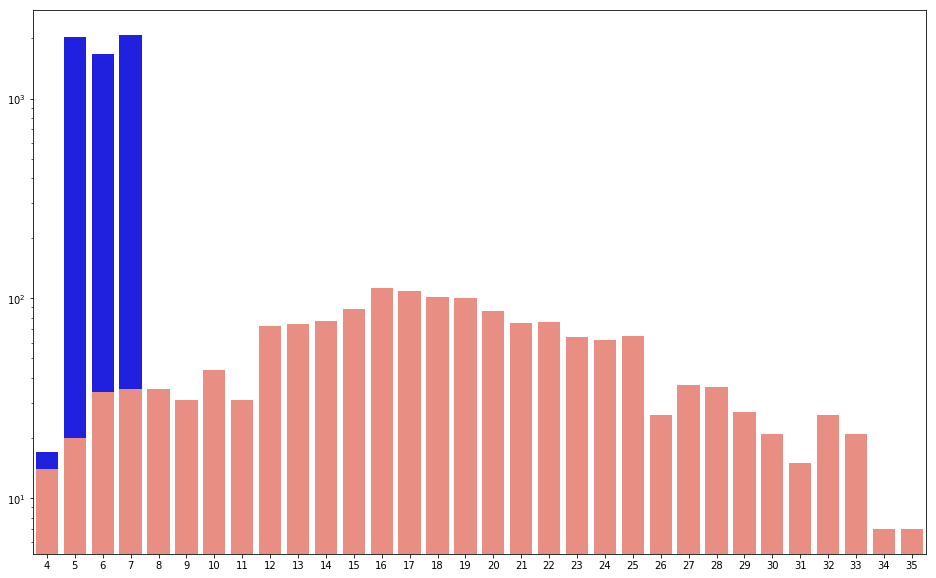

MPD average hops:	18.21+/-6.68, (n=1629)
MP R2R average hops:	6.00+/-0.85, (n=5798)


In [146]:
# Visualize tuple path distances.
bin_size = 1

freq_of_task_ds_count_bins = {}
for c in task_ds:
    cbin = c // bin_size
    if cbin not in freq_of_task_ds_count_bins:
        freq_of_task_ds_count_bins[cbin] = 0
    freq_of_task_ds_count_bins[cbin] += 1

freq_of_mp_ds_count_bins = {}
for c in mp_ds:
    cbin = c // bin_size
    if cbin not in freq_of_mp_ds_count_bins:
        freq_of_mp_ds_count_bins[cbin] = 0
    freq_of_mp_ds_count_bins[cbin] += 1

for cbin in range(min(min(freq_of_mp_ds_count_bins), min(freq_of_task_ds_count_bins)),
                  max(max(freq_of_mp_ds_count_bins), max(freq_of_task_ds_count_bins)) + 1):
    if cbin not in freq_of_mp_ds_count_bins:
        freq_of_mp_ds_count_bins[cbin] = 0
    if cbin not in freq_of_task_ds_count_bins:
        freq_of_task_ds_count_bins[cbin] = 0

fig, ax = plt.subplots(figsize=(16, 10))
g1 = sns.barplot(ax=ax,
                 x=[k * bin_size for k in freq_of_mp_ds_count_bins],
                 y=[freq_of_mp_ds_count_bins[k] for k in freq_of_mp_ds_count_bins],
                 color="blue")
g2 = sns.barplot(ax=ax,
                 x=[k * bin_size for k in freq_of_task_ds_count_bins],
                 y=[freq_of_task_ds_count_bins[k] for k in freq_of_task_ds_count_bins],
                 color="salmon")
ax.set(yscale="log")
plt.show()

print("MPD average hops:\t%.2f+/-%.2f, (n=%d)" % (np.mean(task_ds), np.std(task_ds), len(task_ds)))
print("MP R2R average hops:\t%.2f+/-%.2f, (n=%d)" % (np.mean(mp_ds), np.std(mp_ds), len(mp_ds)))

In [147]:
# Load games data.
with open(games_fn, 'r') as f:
    games = pd.read_json(json.load(f))

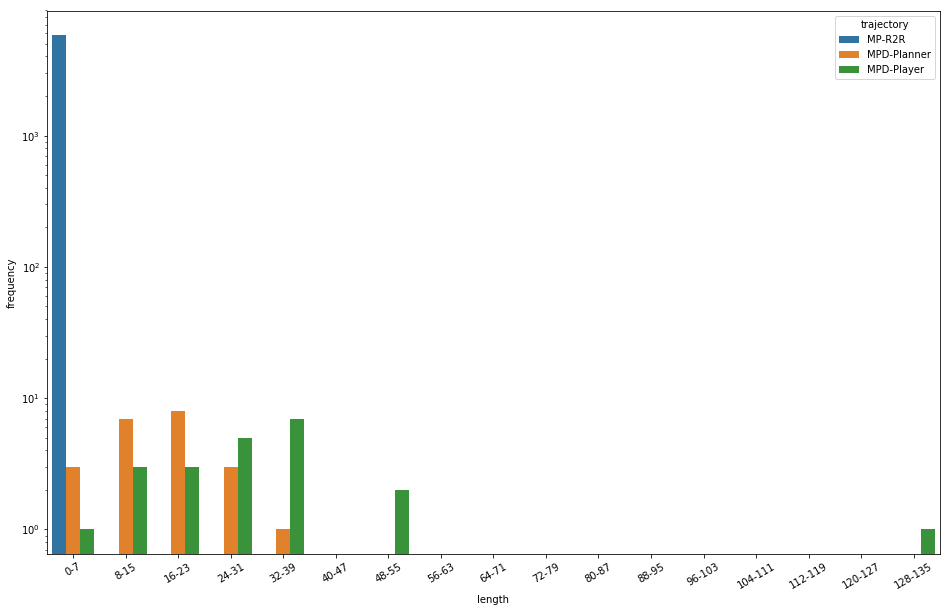

MP R2R average hops:	6.00+/-0.85, (n=5798)
MPD Player average hops:	33.14+/-24.26, (n=22)
MPD Planner average hops:	17.05+/-7.01, (n=22)


In [148]:
# Examine distribution of dialog navigation lengths versus MatterPort.
bin_size = 8

ins_ds = [len(games['planner_nav_steps'][idx]) for idx in games.index]
freq_of_ins_ds_count_bins = {}
for c in ins_ds:
    cbin = c // bin_size
    if cbin not in freq_of_ins_ds_count_bins:
        freq_of_ins_ds_count_bins[cbin] = 0
    freq_of_ins_ds_count_bins[cbin] += 1
    
player_ds = [len(games['nav_steps'][idx]) for idx in games.index]
freq_of_player_ds_count_bins = {}
for c in player_ds:
    cbin = c // bin_size
    if cbin not in freq_of_player_ds_count_bins:
        freq_of_player_ds_count_bins[cbin] = 0
    freq_of_player_ds_count_bins[cbin] += 1

freq_of_mp_ds_count_bins = {}
for c in mp_ds:
    cbin = c // bin_size
    if cbin not in freq_of_mp_ds_count_bins:
        freq_of_mp_ds_count_bins[cbin] = 0
    freq_of_mp_ds_count_bins[cbin] += 1

for cbin in range(min(min(freq_of_mp_ds_count_bins), min(freq_of_ins_ds_count_bins), min(freq_of_player_ds_count_bins)),
                  max(max(freq_of_mp_ds_count_bins), max(freq_of_ins_ds_count_bins), max(freq_of_player_ds_count_bins)) + 1):
    if cbin not in freq_of_mp_ds_count_bins:
        freq_of_mp_ds_count_bins[cbin] = 0
    if cbin not in freq_of_ins_ds_count_bins:
        freq_of_ins_ds_count_bins[cbin] = 0

d = [{'length': "%d-%d" % (k * bin_size, (k+1) * bin_size - 1) if bin_size > 1 else k * bin_size,
      'trajectory': 'MP-R2R',
      'frequency': freq_of_mp_ds_count_bins[k]} for k in freq_of_mp_ds_count_bins]
d.extend([{'length': "%d-%d" % (k * bin_size, (k+1) * bin_size - 1) if bin_size > 1 else k * bin_size,
           'trajectory': 'MPD-Planner',
           'frequency': freq_of_ins_ds_count_bins[k]} for k in freq_of_ins_ds_count_bins])
d.extend([{'length': "%d-%d" % (k * bin_size, (k+1) * bin_size - 1) if bin_size > 1 else k * bin_size,
           'trajectory': 'MPD-Player',
           'frequency': freq_of_player_ds_count_bins[k]} for k in freq_of_player_ds_count_bins])
fig, ax = plt.subplots(figsize=(16, 10))
df = pd.DataFrame(d)
g = sns.barplot(ax=ax, x='length', y='frequency', hue="trajectory", data=df)
ax.set(yscale="log")
if bin_size > 1:
    g.set_xticklabels(g.get_xticklabels(), rotation=30)
plt.show()

print("MP R2R average hops:\t%.2f+/-%.2f, (n=%d)" % (np.mean(mp_ds), np.std(mp_ds), len(mp_ds)))
print("MPD Player average hops:\t%.2f+/-%.2f, (n=%d)" % (np.mean(player_ds), np.std(player_ds), len(player_ds)))
print("MPD Planner average hops:\t%.2f+/-%.2f, (n=%d)" % (np.mean(ins_ds), np.std(ins_ds), len(ins_ds)))

In [149]:
# Load instruction following data.
ins_follow = []
print("fold, instances, scans")
for fold in folds:
    with open(os.path.join(instruction_following_dir, "%s.json" % fold), 'r') as f:
        fold_trajs = json.load(f)
        fold_scans = set([traj['scan'] for traj in fold_trajs])
        ins_follow.extend(fold_trajs)
        print("%s, %d, %d" % (fold, len(fold_trajs), len(fold_scans)))

fold, instances, scans
train, 53, 11
val_seen, 3, 1
val_unseen, 9, 3
test, 19, 4


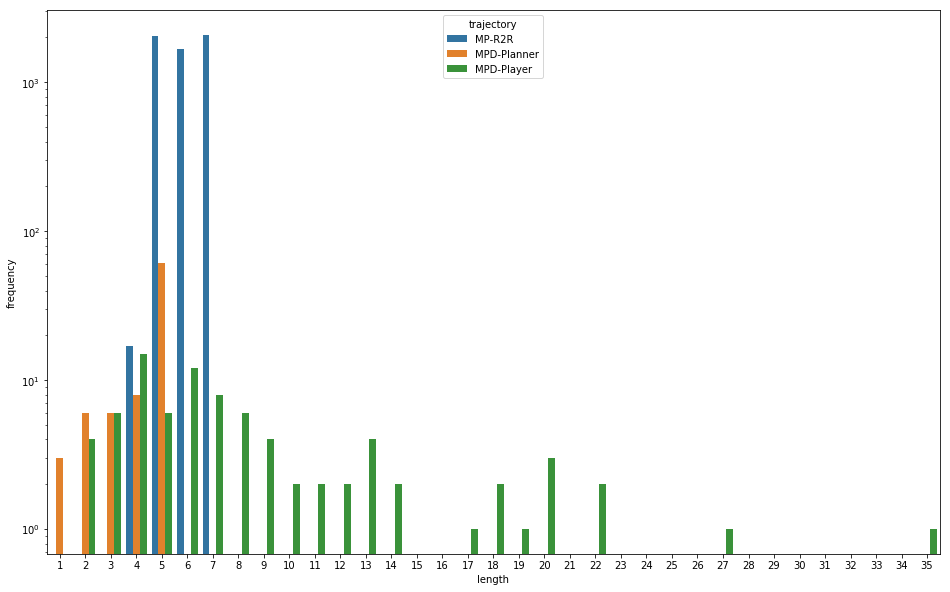

MP R2R average hops:	6.00+/-0.85, (n=5798)
MPD IF Player average hops:	8.48+/-6.15, (n=84)
MPD IF Planner average hops:	4.40+/-1.11, (n=84)


In [150]:
# Examine distribution of instruction following lengths versus MatterPort.
bin_size = 1

ins_ds = [len(task['planner_path']) for task in ins_follow]
freq_of_ins_ds_count_bins = {}
for c in ins_ds:
    cbin = c // bin_size
    if cbin not in freq_of_ins_ds_count_bins:
        freq_of_ins_ds_count_bins[cbin] = 0
    freq_of_ins_ds_count_bins[cbin] += 1
    
player_ds = [len(task['player_path']) for task in ins_follow]
freq_of_player_ds_count_bins = {}
for c in player_ds:
    cbin = c // bin_size
    if cbin not in freq_of_player_ds_count_bins:
        freq_of_player_ds_count_bins[cbin] = 0
    freq_of_player_ds_count_bins[cbin] += 1

freq_of_mp_ds_count_bins = {}
for c in mp_ds:
    cbin = c // bin_size
    if cbin not in freq_of_mp_ds_count_bins:
        freq_of_mp_ds_count_bins[cbin] = 0
    freq_of_mp_ds_count_bins[cbin] += 1

for cbin in range(min(min(freq_of_mp_ds_count_bins), min(freq_of_ins_ds_count_bins), min(freq_of_player_ds_count_bins)),
                  max(max(freq_of_mp_ds_count_bins), max(freq_of_ins_ds_count_bins), max(freq_of_player_ds_count_bins)) + 1):
    if cbin not in freq_of_mp_ds_count_bins:
        freq_of_mp_ds_count_bins[cbin] = 0
    if cbin not in freq_of_ins_ds_count_bins:
        freq_of_ins_ds_count_bins[cbin] = 0

d = [{'length': k * bin_size,
      'trajectory': 'MP-R2R',
      'frequency': freq_of_mp_ds_count_bins[k]} for k in freq_of_mp_ds_count_bins]
d.extend([{'length': k * bin_size,
           'trajectory': 'MPD-Planner',
           'frequency': freq_of_ins_ds_count_bins[k]} for k in freq_of_ins_ds_count_bins])
d.extend([{'length': k * bin_size,
           'trajectory': 'MPD-Player',
           'frequency': freq_of_player_ds_count_bins[k]} for k in freq_of_player_ds_count_bins])
fig, ax = plt.subplots(figsize=(16, 10))
df = pd.DataFrame(d)
g = sns.barplot(ax=ax, x='length', y='frequency', hue="trajectory", data=df)
ax.set(yscale="log")
plt.show()

print("MP R2R average hops:\t%.2f+/-%.2f, (n=%d)" % (np.mean(mp_ds), np.std(mp_ds), len(mp_ds)))
print("MPD IF Player average hops:\t%.2f+/-%.2f, (n=%d)" % (np.mean(player_ds), np.std(player_ds), len(player_ds)))
print("MPD IF Planner average hops:\t%.2f+/-%.2f, (n=%d)" % (np.mean(ins_ds), np.std(ins_ds), len(ins_ds)))

In [160]:
# Get distances and hops across scans.
import networkx as nx
from generate_start_end_pairs import load_nav_graphs
house_hops = {}
house_dists = {}
for house in set(games['scan']):
    graph = load_nav_graphs([house])[house]
    hops = dict(nx.all_pairs_dijkstra_path(graph))
    house_hops[house] = hops
    dists = dict(nx.all_pairs_dijkstra_path_length(graph))
    house_dists[house] = dists

In [182]:
# Estimate human performance on the instruction following and dialog tasks based on official R2R metrics.
def stop_success(scan, path, gold, within_meters=0, within_hops=0):
    return 1 if (house_dists[scan][path[-1]][gold[-1]] <= within_meters or
                 len(house_hops[scan][path[-1]][gold[-1]]) <= within_hops) else 0

def oracle_success(scan, path, gold, within_meters=0, within_hops=0):
    missing_panos = [pano for pano in path if pano not in house_hops[scan]]
    if len(missing_panos) > 0:
        print("WARNING: scan %s connectivity graphs missing panos: " % scan + str(missing_panos))
    path = [pano for pano in path if pano not in missing_panos]
    return 1 if np.any([house_dists[scan][path_pano][gold[-1]] <= within_meters or
                        len(house_hops[scan][path_pano][gold[-1]]) <= within_hops
                        for path_pano in path]) else 0

def spl(scan, path, gold, within_meters=0, within_hops=0):
    return 1. / len(path) if stop_success(scan, path, gold,
                                          within_meters=within_meters, within_hops=within_hops) else 0

def oracle_spl(scan, path, gold, within_meters=0, within_hops=0):
    return 1. / len(path) if oracle_success(scan, path, gold,
                                            within_meters=within_meters, within_hops=within_hops) else 0

ins_sr = 0  # sucess rate for instruction following
ins_osr = 0  # oracle success rate for instruction following
ins_spl = 0  # spl for instruction following
dia_sr = 0  # success rate for task-driven dialog navigation
dia_osr = 0  # oracle success rate for task-driven dialog navigation
dia_spl = 0  # spl for task-driven dialog navigation

for task in ins_follow:
    ins_sr += stop_success(task['scan'], task['player_path'], task['planner_path'], within_meters=3)
    ins_osr += oracle_success(task['scan'], task['player_path'], task['planner_path'], within_meters=3)
    ins_spl += spl(task['scan'], task['player_path'], task['planner_path'], within_meters=3)
ins_sr /= float(len(ins_follow))
ins_osr /= float(len(ins_follow))
ins_spl /= float(len(ins_follow))
print(ins_sr, ins_osr, ins_spl)

for idx in games.index:
    dia_sr += stop_success(games['scan'][idx], games['nav_steps'][idx], games['planner_nav_steps'][idx], 
                           within_meters=3)
    dia_osr += oracle_success(games['scan'][idx], games['nav_steps'][idx], games['planner_nav_steps'][idx],
                              within_meters=3)
    dia_spl += spl(games['scan'][idx], games['nav_steps'][idx], games['planner_nav_steps'][idx], 
                   within_meters=3)
dia_sr /= float(len(games))
dia_osr /= float(len(games))
dia_spl /= float(len(games))
print(dia_sr, dia_osr, dia_spl)

0.34523809523809523 0.7857142857142857 0.0684145880574452
0.6818181818181818 0.9545454545454546 0.03127621504278127
